## Import plików z Google drive

In [7]:
from google.colab import drive
import shutil

# Pobranie datasetu z dysku Google
drive.mount('/content/drive')

# Tworzenie lokalnej kopi datasetu
shutil.copytree('/content/drive/MyDrive/chest_xray/chest_xray', '/content/data/chest_xray/')



Mounted at /content/drive


'/content/data/chest_xray/'

# Ładowanie plików

In [1]:
# Lokalizacja poszczególnych datasetów
train_root = '/content/data/chest_xray/train/'
val_root = '/content/data/chest_xray/val/'
test_root = '/content/data/chest_xray/test/'

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random
import numpy as np

In [3]:
# Ustawienie seed'a aby zapewnić powtarzalność
random_seed = 12345 # 12345 jest domyślne
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)


# Funkcja do balansowania datasetu train
def select_balanced_subset(dataset, num_samples_per_class, random_seed):
    """
    Tworzy zbalansowany dataset z podanego pytoech datasetu .

    Args:
        dataset (torch.utils.data.Dataset): Źródłowy dataset.
        num_samples_per_class (int): Ile próbek z datasetu wybrać.
        random_seed (int): Random seed dla powtarzalności.

    Returns:
        torch.utils.data.Subset: Subset ze zbalansowanymi klasami.

    Ta funkcja iteruje obie klasy w datasecie, wybiera losowe
    indeksy i zabiera określoną ilość próbek aby stworzyć nowy zbalansowany dataset.
    """
    indices = []
    for class_idx in range(len(dataset.classes)):
        class_indices = [idx for idx, label in enumerate(dataset.targets) if label == class_idx]
        random.Random(random_seed).shuffle(class_indices)  # Powtarzalność
        class_indices = class_indices[:num_samples_per_class]
        indices.extend(class_indices)
    return Subset(dataset, indices)

Dataset train jest datasetem niezbalansowanym ale dzięki temu ,że potrzebujemy mało danych możemy spokojnie stworzyć zbalansowany dataset

In [4]:
# Definicja transformacji
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
# WAŻNE, ile próbek na klase wybieramy do uczenia klasyfikatora
num_samples_per_class = 100

In [8]:
# Ładowanie obrazów z folderów
train_dataset = datasets.ImageFolder(root=train_root, transform=data_transform)
val_dataset = datasets.ImageFolder(root=val_root, transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_root, transform=data_transform)


# Select a balanced subset of the training dataset
balanced_train_dataset = select_balanced_subset(train_dataset, num_samples_per_class, random_seed)

# Data loadery w tym dla zbalansowanego treningu
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Debug: Sprawdź ile orazów jest w każdym datasecie
print(f"Training set: {len(balanced_train_loader.dataset)} images")
print(f"Validation set: {len(val_loader.dataset)} images")
print(f"Test set: {len(test_loader.dataset)} images")

Training set: 200 images
Validation set: 16 images
Test set: 624 images


## Tworzenie i trening sieci

In [9]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.svm import  SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np


### Sieć neuronowa DenseNet

Ten model nie będzie trenowany, będzie służył wyłącznie jako ekstraktor cech do nauczenia klasyfikatora SVC. Jedyne opóźnienia jakie on wnosi to jego czas inferencji i jak długo zajmuje jego pobranie. Odrzucamy również ostatnią warstwę.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_densent = models.densenet161(weights='DEFAULT')# Wczytywanie modelu pretrained DenseNet161
model_densent = nn.Sequential(*list(model_densent.children())[:-1]) # Usunięcie ostatinej warstwy [klasyfikatora]
model_densent = model_densent.to(device)
model_densent.eval() #Ten model nie będzie trenowany więc pozostanie w fazie ewaluacji

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 260MB/s]


Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): 

In [139]:
# Funkcja ekstraktora zmiennych
def extract_features(model, dataloader,device):
    """
    Ekstraktuje cechy z danych za pomocą podanego modelu.

    Args:
        model (torch.nn.Module): Model do ekstrakcji cech.
        dataloader (torch.utils.data.DataLoader): DataLoader zawierający dane.
        device (torch.device): Urządzenie 'cuda' (GPU) lub 'cpu'.

    Returns:
        numpy.ndarray, numpy.ndarray: Tablice cech i odpowiadających im etykiet.

    Ta funkcja iteruje przez dataloader, przesyła dane przez model,
    zbiera wyjścia cech oraz odpowiadające im etykiety i zwraca je jako numpy arrays.
    """
    features = []
    labels = []
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)
            output = model(data)
            features.append(output.cpu().numpy())
            labels.append(label.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [12]:
# Ekstrakcja zmiennych dla każdego datasetu
train_features, train_labels = extract_features(model_densent, balanced_train_loader,device)
test_features, test_labels = extract_features(model_densent, test_loader,device)
val_features, val_labels = extract_features(model_densent, val_loader,device)

# Spłaszczenie zbiorów tak by można było na nich ternować klasyfikator SVC
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat  = test_features.reshape(test_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)

#### Dodatkowe miejsce do modyfikacji ilosci próbek by uniknąć zbędnego szukania

In [128]:
# WAŻNE, ile próbek na klase wybieramy do uczenia klasyfikatora
num_samples_per_class = 100

random_seed = 12345 # 12345 jest domyślne
# Zbalansowany zbiór danych trenignowych
balanced_train_dataset = select_balanced_subset(train_dataset, num_samples_per_class, random_seed)
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)

train_features, train_labels = extract_features(model_densent, balanced_train_loader,device)
train_features_flat = train_features.reshape(train_features.shape[0], -1)

### Klasyfikator SVC

In [14]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [129]:
# Zbiór parametrów zoptymalizowanych dla najwyższego F1 otrzymanye z wcześniejszej optymalizacji z pomocą Optuna

param ={ # optymalne dla 200 obrazów, czyli num_samples_per_class = 100
        'clf__C': 3.749935,
        'clf__kernel': 'poly',
        'clf__gamma': 'auto',
        'clf__degree': 3,
        'clf__coef0': 0.109403,
        'clf__tol': 0.002352,
        'clf__max_iter': 455,
    }

# param ={ # optymalne dla 100 obrazów, czyli num_samples_per_class = 50
#         'clf__C': 1.865911,
#         'clf__kernel': 'poly',
#         'clf__gamma': 'scale',
#         'clf__degree': 5,
#         'clf__coef0': 0.736491,
#         'clf__tol': 0.001910,
#         'clf__max_iter': 113,
#     }

# param = { # optymalne dla 50 obrazów, przy seed 123 aby zapewnić dobrej jakosci obrazy
#         'clf__C': 1.865911,
#         'clf__kernel': 'poly',
#         'clf__gamma': 'scale',
#         'clf__degree': 5,
#         'clf__coef0': 0.736491,
#         'clf__tol': 0.001910,
#         'clf__max_iter': 113,
# }

Jedyny algorytm który będzie faktycznie trenowany na danych to klasyfikator SVC, przyjmuje on spłaszczone ekstraktowane cechy przez DeepNet161, a w opowiedzi podaje do jakiej grupy przynależy dany obraz. Dodatkowo istnieje również opcja aby klasyfikator podał również prawdopodobieństwo poprawności rezultatu, co jest cenną cechą w naszym przypadku.

In [130]:
# Stworzenie pipeline dla klasyfikatora SVC
model_svc = Pipeline([('scaler', StandardScaler()),
                      ('clf', SVC(probability=True))])# gdy chcemy poznać prawdopodobieństwo poprawności rezultatu, inaczej ustawić False

# Ustawienie parametrów
model_svc.set_params(**param)

# Trening modelu
model_svc.fit(train_features_flat, train_labels)

# Kalkulowanie F1
preds = model_svc.predict(train_features_flat)
f1 = f1_score(train_labels, preds)
acc = accuracy_score(train_labels, preds)
precision = precision_score(train_labels, preds)
recall = recall_score(train_labels, preds)
cm = confusion_matrix(train_labels, preds)

print(f'Statystyki dla zbioru treningowego, F1 {f1} , Accuracy {acc} , Precyzja {precision} , Recall {recall}')
print('Confusion matrix dla zbioru treningowego ')
print(cm)


# Kalkulowanie F1
preds = model_svc.predict(val_features_flat)
f1 = f1_score(val_labels, preds)
acc = accuracy_score(val_labels, preds)
precision = precision_score(val_labels, preds)
recall = recall_score(val_labels, preds)
cm = confusion_matrix(val_labels, preds)

print(f'Statystyki dla zbioru walidacyjnego, F1 {f1} , Accuracy {acc} , Precyzja {precision} , Recall {recall}')
print('Confusion matrix dla zbioru walidacyjnego ')
print(cm)

# Kalkulowanie F1
preds = model_svc.predict(test_features_flat)
f1 = f1_score(test_labels, preds)
acc = accuracy_score(test_labels, preds)
precision = precision_score(test_labels, preds)
recall = recall_score(test_labels, preds)
cm = confusion_matrix(test_labels, preds)

print(f'Statystyki dla zbioru testowego, F1 {f1} , Accuracy {acc} , Precyzja {precision} , Recall {recall}')
print('Confusion matrix dla zbioru testowego ')
print(cm)

Statystyki dla zbioru treningowego, F1 1.0 , Accuracy 1.0 , Precyzja 1.0 , Recall 1.0
Confusion matrix dla zbioru treningowego 
[[100   0]
 [  0 100]]
Statystyki dla zbioru walidacyjnego, F1 0.9411764705882353 , Accuracy 0.9375 , Precyzja 0.8888888888888888 , Recall 1.0
Confusion matrix dla zbioru walidacyjnego 
[[7 1]
 [0 8]]
Statystyki dla zbioru testowego, F1 0.9250645994832041 , Accuracy 0.907051282051282 , Precyzja 0.9322916666666666 , Recall 0.9179487179487179
Confusion matrix dla zbioru testowego 
[[208  26]
 [ 32 358]]


In [79]:
import joblib

# Zapisywanie wytrenowaneg klasyfikatora
joblib.dump(model_svc, 'svc_classifier_model.pkl')

# ładowanie zapisanego klasyfikatora
model_svc = joblib.load('svc_classifier_model.pkl')


## Gotowy Pipeline

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full ba

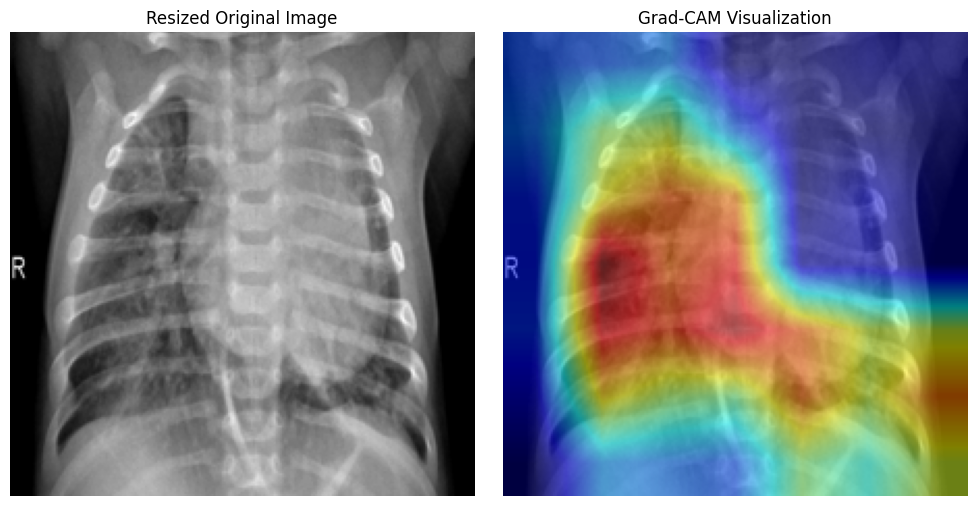

Prediction: 0, Probability: 0.87
Predicted class: 0


In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Świerzy densenet161 dla GradCAM
def initialize_densenet_for_gradcam():
    """
    Inicjuje model DenseNet161 z wczytanymi wagami i przestawia go w tryb ewaluacji.

    Returns:
        torch.nn.Module: Zainicjalizowany model DenseNet161.
    """
    model = models.densenet161(pretrained=True)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    return model

# DenseNet161 dla ekstrakcji zmiennych
def initialize_densenet_for_extraction():
    """
    Inicjuje model DenseNet161 bez ostatniej warstwy przestawia go w tryb ewaluacji.

    Returns:
        torch.nn.Module: Zainicjalizowany model DenseNet161 do ekstrakcji cech.
    """
    model = models.densenet161(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])  # Usunięcie ostatniej warstwy
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    return model

# Ładuj pojedyńczy obraz
def load_image(image_path):
    """
    Ładuje obraz z podanej ścieżki i przekształca go do postaci tensora.

    Args:
        image_path (str): Ścieżka do pliku z obrazem.

    Returns:
        PIL.Image.Image, torch.Tensor: Załadowany obraz PIL oraz tensor obrazu.
    """
    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0)  # Batch dim
    return img, img_tensor

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer = dict([*self.model.named_modules()])[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        target = output[0, class_idx]
        target.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[2:])
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

def show_cam_on_image(img, mask):
    """
    Nakłada heatmap na oryginalny obraz.

    Args:
        img (numpy.ndarray): Oryginalny obraz w formacie numpy.ndarray.
        mask (numpy.ndarray): Mapa do nałożenia, wartości skalowanymi od [0, 1].

    Returns:
        numpy.ndarray: Obraz heatmap w formacie numpy.ndarray.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def model_workflow_pipeline(file_path):
    """
    Przepływ pracy modelu obejmujący wczytanie obrazu, Grad-CAM,
    ekstrakcję cech za pomocą DenseNet i predykcję przy użyciu klasyfikatora SVC.

    Args:
        file_path (str): Ścieżka do pliku obrazu do przetworzenia.

    Returns:
        int: Przewidywana klasa obrazu przez model SVC.
    """
    # Wczytaj obraz
    img, img_tensor = load_image(file_path)
    img_tensor = img_tensor.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Inicjalizacja modeli
    model_densenet = initialize_densenet_for_extraction()
    grad_cam = GradCAM(initialize_densenet_for_gradcam(), 'features.denseblock4.denselayer24.conv2') # zmienić na relu2 dla bardziej punktowego gradcam

    # Grad-CAM
    mask = 1-grad_cam.generate(img_tensor)
    result = show_cam_on_image(np.array(img.resize((224, 224))) / 255.0, mask)

    # Wyświetl originał i Grad-CAM overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(img.resize((224, 224))))
    plt.title('Originalny Obraz')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Ekstrackca cech przez DeepNet dla SVC
    with torch.no_grad():
        features = model_densenet(img_tensor)
        features = features.view(features.size(0), -1).cpu().detach().numpy()

    # Flatten features
    flat_features = features.reshape(1, -1)

    # Predict using SVC model
    prediction = model_svc.predict(flat_features)[0]
    probability = model_svc.predict_proba(flat_features)[0]

    print(f'Prediction: {prediction}, Probability: {probability.max():.2f}')

    return prediction

# Przykład użycia
file_path = '/content/data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
prediction = model_workflow_pipeline(file_path)
print(f'Predicted class: {prediction}')


Idea dla użytkownika jest następująca, po wytrenowaniu klasyfikatora SVC używa jej bezpośrednio w model_workflow_pipeline() otrzymując w odpowiedzi obrazek GradCAM i predykcję wraz z poziomem jej prawdopodobieństwa.

---


 W przypadku gdy zdobędziemy więcej danych lub problem zmieni się na tyle ,że odkryjemy dryf danych to po zdobyciu nowego datasetu wystarczy przejśc do funkcji w sekcji Hypertuning, opcja podstawowa oparta o GridScan jest dość szybka i daje całkiem dobrą informację o możliwych osiągach klasyfikatora. Jeśli są one satysfakcjonujące to można ich używać natychmiast do wytrenowania klasyfikatora, jednakże osobiście proponowałbym poddać się zaawansowanemu tuningowi z pomocą Optuny. Jest to dłuższe i niezbyt powtarzalne, ale zazwyczaj dodaje od 0.03 do 0.06 do F1 w porównaniu do GridScan.

## Interpretowalność wyników GradCAM

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


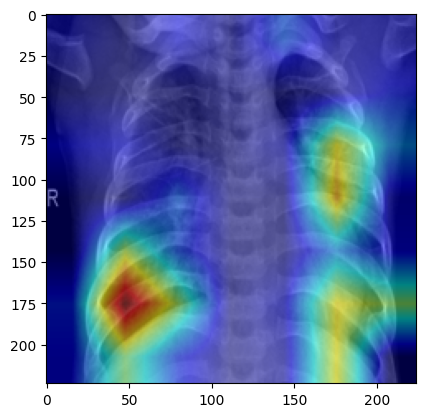

In [121]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Nowy DenseNet161 model
model = models.densenet161(weights='DEFAULT')
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# Ładuj pojedyńczy obraz
def load_image(image_path):
    """
    Ładuje obraz z podanej ścieżki i przekształca go do postaci tensora.

    Args:
        image_path (str): Ścieżka do pliku z obrazem.

    Returns:
        PIL.Image.Image, torch.Tensor: Załadowany obraz PIL oraz tensor obrazu.
    """
    img = Image.open(image_path).convert('RGB')
    img_tensor = data_transform(img).unsqueeze(0)  # Batch dim
    return img, img_tensor

# Hooki do gradientów
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer = dict([*self.model.named_modules()])[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        target = output[0, class_idx]
        target.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_tensor.shape[2:])
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

def show_cam_on_image(img, mask):
    """
    Nakłada heatmap na oryginalny obraz.

    Args:
        img (numpy.ndarray): Oryginalny obraz w formacie numpy.ndarray.
        mask (numpy.ndarray): Mapa do nałożenia, wartości skalowanymi od [0, 1].

    Returns:
        numpy.ndarray: Obraz heatmap w formacie numpy.ndarray.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


# Wczytaj obraz
image_path = '/content/data/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'
img, img_tensor = load_image(image_path)
img_tensor = img_tensor.to('cuda' if torch.cuda.is_available() else 'cpu')

# Grad-CAM
grad_cam = GradCAM(model, 'features.denseblock4.denselayer24.relu2')#conv2 jest wiekszy obszar, relu2 jest bardziej precyzyjne
mask = 1-grad_cam.generate(img_tensor)
result = show_cam_on_image(np.array(img.resize((224, 224))) / 255.0, mask)

# Obraz wraz z Grad-CAM
plt.imshow(result)
plt.show()


## Hypertuning klasyfikatora

In [87]:
# Hyperparameter tuning
def evaluate_model(model, params, train_features, train_labels, val_features, val_labels):
    """
    Ocena modelu przy użyciu GridSearchCV oraz raportowanie
    metryk na danach walidacyjnych.

    Args:
        model (sklearn estimator): Bazowy model do tuningu.
        params (dict): Parametry do przeszukiwania.
        train_features (numpy.ndarray): Cechy zbioru treningowego.
        train_labels (numpy.ndarray): Etykiety zbioru treningowego.
        val_features (numpy.ndarray): Cechy zbioru walidacyjnego.
        val_labels (numpy.ndarray): Etykiety zbioru walidacyjnego.

    Returns:
        sklearn estimator: Najlepszy estymator znaleziony przez GridSearchCV.
        float: Wynik celności na zbiorze walidacyjnym.
        float: Wynik precision na zbiorze walidacyjnym.
        float: Wynik recall na zbiorze walidacyjnym.
        float: Wynik F1 na zbiorze walidacyjnym.
        numpy.ndarray: Confusion matrix na zbiorze walidacyjnym.

    Funkcja ta przeprowadza tuning za pomocą GridSearchCV,
    ocenia najlepszy model na zbiorze walidacyjnym i zwraca metryki.
    """
    grid_search = GridSearchCV(model, params, scoring='f1', cv=3, n_jobs=-1)
    grid_search.fit(train_features, train_labels)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    predictions = best_model.predict(val_features)
    # print(predictions)

    if set(predictions) == {1, -1}:
      predictions = np.where(predictions == -1, 0, 1)
    # print(predictions)

    acc = accuracy_score(val_labels, predictions)
    # print(acc)
    precision = precision_score(val_labels, predictions)
    # print(precision)
    recall = recall_score(val_labels, predictions)
    # print(recall)
    f1 = f1_score(val_labels, predictions)
    # print(f1)
    cm = confusion_matrix(val_labels, predictions)

    print(f'Njlpesze parametry: {best_params}')

    return best_model, acc, precision, recall, f1, cm

In [92]:
model = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
params = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__gamma': ['scale', 'auto']
}

# Ewaluacja modelu
best_model, acc, precision, recall, f1, cm = evaluate_model(model, params, train_features_flat, train_labels, val_features_flat, val_labels)

print(f'Best Model: {best_model}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(cm)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(C=10))])
Accuracy: 0.7676
Precision: 0.7407
Recall: 0.9667
F1 Score: 0.8387
Confusion Matrix:
[[102 132]
 [ 13 377]]


### Zaawansowany tunign z biblioteką Optuna

In [15]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


In [90]:
import optuna
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# Cel to maksymalizacja F1
def objective(trial):
    param = {
        'clf__C': trial.suggest_float('clf__C', 0.01, 100, log=True),
        'clf__kernel': trial.suggest_categorical('clf__kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
        'clf__gamma': trial.suggest_categorical('clf__gamma', ['scale', 'auto']),
        'clf__degree': trial.suggest_int('clf__degree', 2, 5),
        'clf__coef0': trial.suggest_float('clf__coef0', 0.0, 1.0),
        'clf__tol': trial.suggest_float('clf__tol', 1e-4, 1e-2, log=True),
        'clf__max_iter': trial.suggest_int('clf__max_iter', 100, 1000),
    }

    # Pipeline
    model = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])

    # Update parametrów
    model.set_params(**param)

    # Train
    model.fit(train_features_flat, train_labels)

    # Kalkulacja F1 score
    preds = model.predict(val_features_flat)
    f1 = f1_score(val_labels, preds)

    return f1

# Rozpocząć tuning i maksymalizować f1
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=60*20,show_progress_bar=True)  # Stop po 20 min

# Top 5 trialów
top_trials = study.trials_dataframe().sort_values('value', ascending=False).head(5)

# Top 5 parameterów
print("Top 5 Parametrów :")
print(top_trials)


[I 2024-06-12 18:37:20,446] A new study created in memory with name: no-name-040e089e-9163-40fd-9f51-2892e8cd78ba


   0%|          | 00:00/20:00

[I 2024-06-12 18:37:32,212] Trial 0 finished with value: 0.8912529550827423 and parameters: {'clf__C': 0.7988834493179476, 'clf__kernel': 'linear', 'clf__gamma': 'scale', 'clf__degree': 3, 'clf__coef0': 0.4556396739721602, 'clf__tol': 0.0076645539458702104, 'clf__max_iter': 757}. Best is trial 0 with value: 0.8912529550827423.
[I 2024-06-12 18:37:38,297] Trial 1 finished with value: 0.8915094339622641 and parameters: {'clf__C': 5.1749006597572205, 'clf__kernel': 'sigmoid', 'clf__gamma': 'auto', 'clf__degree': 3, 'clf__coef0': 0.059441141005349696, 'clf__tol': 0.0016282330428400104, 'clf__max_iter': 567}. Best is trial 1 with value: 0.8915094339622641.
[I 2024-06-12 18:37:45,856] Trial 2 finished with value: 0.8912529550827423 and parameters: {'clf__C': 0.6777388102068013, 'clf__kernel': 'linear', 'clf__gamma': 'auto', 'clf__degree': 2, 'clf__coef0': 0.2247038677874753, 'clf__tol': 0.007301330834845973, 'clf__max_iter': 438}. Best is trial 1 with value: 0.8915094339622641.
[I 2024-06-12

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=118).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2024-06-12 18:38:44,510] Trial 10 finished with value: 0.8574660633484162 and parameters: {'clf__C': 57.719435168798796, 'clf__kernel': 'rbf', 'clf__gamma': 'scale', 'clf__degree': 4, 'clf__coef0': 0.7207981087651925, 'clf__tol': 0.000647824468945797, 'clf__max_iter': 118}. Best is trial 9 with value: 0.8963855421686747.
[I 2024-06-12 18:38:54,009] Trial 11 finished with value: 0.8967193195625758 and parameters: {'clf__C': 0.09999647778104832, 'clf__kernel': 'poly', 'clf__gamma': 'scale', 'clf__degree': 5, 'clf__coef0': 0.994443851895525, 'clf__tol': 0.0005855631922925995, 'clf__max_iter': 561}. Best is trial 11 with value: 0.8967193195625758.
[I 2024-06-12 18:39:03,605] Trial 12 finished with value: 0.8954838709677418 and parameters: {'clf__C': 0.09732096063640482, 'clf__kernel': 'poly', 'clf__gamma': 'scale', 'clf__degree': 5, 'clf__coef0': 0.7219708786564285, 'clf__tol': 0.0007475921405761997, 'clf__max_iter': 576}. Best is trial 11 with value: 0.8967193195625758.
[I 2024-06-12 1

KeyboardInterrupt: 

# Pytania i odpowiedzi meta

Q: Dlaczego rozwiązanie few shot zamiast normalnej klasyfikacji?


---


A: Ponieważ dobre dane są zazwyczaj rzadkie i w przypadku danych medycznych zazwyczaj trudno dostępne. Zdarzyć sie może że np. przy zmiania urządzenia zdjęcia będą na tyle inna aby wymusić ponowny trening, co można zrobić szybciej z rozwiązaniem few shot. Dodatkowo zakładam że wiekszośc poda takie rozwiązanie więc zagrywam Va Bank i oferuję rozwiązanie które prawdopodobnie nie osiągnie najwyższego F1 ale ma wiele innych pozytywnych aspektów

Q: Dlaczego nie generatywne ai?


---


A: Najpierw próbowałem stworzyć CNN-VAE ale jak się okazuje przy dostępnej mi mocy obliczeniowej i jak mało jest danych bardzo ciężko o dobrą rekonstruckję obrazu więc porzuciłem to rozwiązanie. Prawdopodobnie GAN, StableDiffusion czy może Flow based model jest w stanie wygenerować dobre rekonstrukcje lecz nie jestem pewien czy rezultat byłby tak samo dobry jak moje rozwiązanie

Q: Dlaczego nie klasyczny algorytm few shot?


---


A: Mam mieszanie odczucia względem sieci syjamskich, więc pewnie dlatego. Jednakże bardziej wchodziło tutaj w grę pytanie czy taka sieć byłaby w stanie uzyskać lepsze rozwiązanie niż te zawarte w tym notatniku? Pewnie tak ale optymalizacja tego brzmi jak zabawa dla masochistów.

Q: Skąd taki pomysł?


---


A: Mocno zainspirowane dwoma artykułami, po pierwsze poniższy artykuł https://arxiv.org/pdf/2101.00562 gdzie wykorzystano sieć MLP jako ostatni fragment i pobito najpopularniejsze algorytmy few-shot. Osobiście kiedy pierwszy raz to przeczytałem to byłem bardzo zaskoczony, ale muszę samemu przyznać mieli rację i takie dwuczłonowe rozwiązania naprawdę działają nieźle i są zdecydowanie prostsze w obsłudze. Drugim artykułem jest https://ieeexplore.ieee.org/document/9945469 gdzie zastosowali to rozwiązanie do bardzo zbliżonego problemu, niestety nie mam do niego dostępu więc ciężko mi spekulować jakich sztuczek użyli aby uzyskać rezultaty jakimi się chwalą w abstrakcie

Q: Czy próbowałeś inne sieci neuronowe?


---


A: Tak, przetestowałem ich około 35 różnych sieci i rozmiarów, od ResNet aż do rozwiązań opartych na transformerach jak np. Swin. Najlepiej sprawdził się jednak stary dobry DeepNet, chodziarz RegNet też był bardzo dobry. Prawdopodobnie pośród sieci które badałem jest lepsza sieć i najprawdopodboniej gdyby zamiast ostatniej warstwy usuwać przedostatnie ect. to znalazłby się lepszy kandydat.

Q: Gdybyś mógł to jaki bajer byś jeszcze dodał?


---


A: Myślałem nad wysyłaniem zdjęcia oryginalnego i Grad-CAM do chatGPT aby mógł od razu wystawic pisemną diagnozę i powiedzieć jak głębokie są zmiany itp. Tak się nie stanie, bo nie mam tokenów, aby je na to wykorzystać, dodatkowo dość długo by zajęło zanim odpowiedzi byłyby klinicznie wartościowe.